In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import urllib
import netCDF4 as nc
import datetime
import scipy.interpolate as interp
import cmath
import os

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.basemap import Basemap
import bisect
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
class Iceberg:
    
    def __init__(self, id_num, times, t2000, lats, lons, size):
        self.id_num = id_num
        self.times = times
        self.t2000 = t2000
        self.times_ref0 = self.get_times_ref0(self.times)
        self.lats = lats
        self.lons = lons
        
        if type(size) == str:
            self.length, self.width, self.height = self.get_berg_dims(size)
        elif type(size) == list and len(size) == 3:
            self.length, self.width, self.height = size[0], size[1], size[2]
        else:
            print('Invalid size argument')
            
    def get_times_ref0(self, times):
        times_ref0 = []
        t_offset = times[0].hour + times[0].minute/60  # from start of day
        for i in range(len(times)):
            times_ref0.append(round((times[i] - times[0]).days*24 + \
                                    (times[i] - times[0]).seconds/3600 + t_offset, 1))
        return times_ref0
    
    def set_times_ref0(self, times):
        self.times_ref0 = self.get_times_ref0(times)
            
    def get_berg_dims(self, size):
        # Size must be GR, BB, SM, MED, LG, VLG
        # See https://nsidc.org/data/g00807 for more info
        if size == 'GR':
            l = (0+5)/2; w = (0+5)/2; h = (0+1)/2*10
        elif size == 'BB':
            l = (5+15)/2; w = (5+15)/2; h = (1+5)/2*10        
        elif size == 'SM':
            l = (15+60)/2; w = (15+60)/2; h = (5+15)/2*10        
        elif size == 'MED':
            l = (60+120)/2; w = (60+120)/2; h = (15+45)/2*10               
        elif size == 'LG':
            l = (120)/2; w = (120)/2; h = (45+75)/2*10                
        elif size == 'VLG':
            # Sizes have no listed upper bound
            l = (200+200/2)/2; w = (200+200/2)/2; h = (75+75/2)/2*10     
        # This info for GEN is wrong!
        elif size == 'GEN':
            l = (120)/2; w = (120)/2; h = (45+75)/2*10            
        else:
            print('unknown size class')
            l = None; w = None; h = None
        return l, w, h

In [4]:
class MetoceanModel(object):
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        self.x_min = x_min - abs(x_min-x_max) - self.xy_res
        self.x_max = x_max + abs(x_min-x_max) + self.xy_res
        self.y_min = y_min - abs(y_min-y_max) - self.xy_res
        self.y_max = y_max + abs(y_min-y_max) + self.xy_res
        
        if self.t_units == 'hours since 2000-01-01 00:00:00':
            self.t_min = (t_min - pd.Timestamp('2000-01-01')).days*24 + \
                         (t_min - pd.Timestamp('2000-01-01')).seconds/3600 - self.t_res
            self.t_max = (t_max - pd.Timestamp('2000-01-01')).days*24 + \
                         (t_max - pd.Timestamp('2000-01-01')).seconds/3600 + self.t_res
                
        elif self.t_units == 'numpy.datetime64':
            self.t_min = np.datetime64((t_min - pd.Timedelta('{}h'.format(self.t_res))))
            self.t_max = np.datetime64((t_max + pd.Timedelta('{}h'.format(self.t_res)))) 
            
        elif self.t_units == 'hours since 1950-01-01 00:00:00':
            self.t_min = (t_min - pd.Timestamp('1950-01-01')).days*24 + \
                         (t_min - pd.Timestamp('1950-01-01')).seconds/3600 - self.t_res
            self.t_max = (t_max - pd.Timestamp('1950-01-01')).days*24 + \
                         (t_max - pd.Timestamp('1950-01-01')).seconds/3600 + self.t_res
            self.t_min = nc.num2date(self.t_min, self.t_units, self.t_calendar)
            self.t_max = nc.num2date(self.t_max, self.t_units, self.t_calendar)
            self.year_min = str(self.t_min.year)
            self.year_max = str(self.t_max.year)
            self.month_min = str(self.t_min.month)
            self.month_max = str(self.t_max.month)
            self.day_min = str(self.t_min.day)
            self.day_max = str(self.t_max.day)

            if len(self.month_min) == 1:
                self.month_min = '0' + self.month_min
            if len(self.day_min) == 1:
                self.day_min = '0' + self.day_min
            if len(self.month_max) == 1:
                self.month_max = '0' + self.month_max
            if len(self.day_max) == 1:
                self.day_max = '0' + self.day_max
                
        elif self.t_units == 'hours since 1900-01-01 00:00:00.0 00:00':
            self.t_min = (t_min - pd.Timestamp('1900-01-01')).days*24 + \
                         (t_min - pd.Timestamp('1900-01-01')).seconds/3600 - self.t_res
            self.t_max = (t_max - pd.Timestamp('1900-01-01')).days*24 + \
                         (t_max - pd.Timestamp('1900-01-01')).seconds/3600 + self.t_res
            self.t_min = nc.num2date(self.t_min, self.t_units, self.t_calendar)
            self.t_max = nc.num2date(self.t_max, self.t_units, self.t_calendar)
            self.year_min = str(self.t_min.year)
            self.year_max = str(self.t_max.year)
            self.month_min = str(self.t_min.month)
            self.month_max = str(self.t_max.month)
            self.day_min = str(self.t_min.day)
            self.day_max = str(self.t_max.day)

            if len(self.month_min) == 1:
                self.month_min = '0' + self.month_min
            if len(self.day_min) == 1:
                self.day_min = '0' + self.day_min
            if len(self.month_max) == 1:
                self.month_max = '0' + self.month_max
            if len(self.day_max) == 1:
                self.day_max = '0' + self.day_max

In [5]:
class GLBv008(MetoceanModel):
    url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'
    xy_res = 0.08  # spatial resolution in degrees lat/lon
    t_res = 3  # temporal resolution in hours
    t_units = 'hours since 2000-01-01 00:00:00'
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        self.ds = xr.open_dataset(self.url, decode_times=False).sel(depth=0.0, 
                  lat = slice(self.y_min, self.y_max), 
                  lon = slice(self.x_min, self.x_max), 
                  time = slice(self.t_min, self.t_max))
        self.times = self.ds.variables['time'].values[:]
        self.datetimes = nc.num2date(testobj.ds.variables['time'].values[:],
                                     testobj.ds.time.units,
                                     testobj.ds.time.calendar)
        self.t2000 = self.times
        self.lats = np.asarray(self.ds.lat)
        self.lons = np.asarray(self.ds.lon)
        self.water_u = np.asarray(self.ds.water_u)
        self.water_v = np.asarray(self.ds.water_v)
        self.water_temp = np.asarray(self.ds.water_temp)
        self.water_u_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_u)
        self.water_v_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_v)
        self.water_temp_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_temp)

In [6]:
class Navgem(MetoceanModel):
    url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'
    xy_res = 0.5  # spatial resolution in degrees lat/lon
    t_res = 6  # temporal resolution in hours
    t_units = 'numpy.datetime64'
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        self.ds = xr.open_dataset(self.url)
        self.ds = self.ds.sel(time = slice(self.t_min, self.t_max),
                  latitude = slice(self.y_min, self.y_max), 
                  longitude = slice(self.x_min, self.x_max))
        self.times = self.ds.variables['time']
        self.datetimes = []
        for i in (self.times - np.datetime64(0, 's'))/ np.timedelta64(1, 's'):
            self.datetimes.append(datetime.datetime.utcfromtimestamp(i))
        self.lats = np.asarray(self.ds.latitude)
        self.lons = np.asarray(self.ds.longitude)
        self.wind_u = np.asarray(self.ds.wnd_ucmp_height_above_ground)
        self.wind_v = np.asarray(self.ds.wnd_vcmp_height_above_ground)

In [7]:
class ECMWF_Ocean(MetoceanModel):
    # product identifier: GLOBAL_ANALYSIS_FORECAST_PHY_001_024
    #path = '/media/evankielley/hd2/ECMWF/ocean/daily/'
    path = '/home/evankielley/Data/ECMWF/ocean/daily/'
    all_files = sorted(os.listdir(path))
    fname = '{}{}{}.nc' #.format(year, month, day)
    xy_res = 1/12  # spatial resolution in degrees lat/lon
    t_res = 1  # temporal resolution in hours
    t_units = 'hours since 1950-01-01 00:00:00'
    t_calendar = 'standard'
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        if self.t_min.year == self.t_max.year and self.t_min.month == self.t_max.month and self.t_min.day == self.t_max.day:
            self.ds = nc.Dataset(self.path + self.fname.format(self.year_min, self.month_min, self.day_min))
        else:
            self.files = self.all_files[self.all_files.index(self.fname.format(self.year_min, self.month_min, self.day_min)):
                                   self.all_files.index(self.fname.format(self.year_max, self.month_max, self.day_max))+1]
            for i in range(len(self.files)):
                self.files[i] = self.path + self.files[i]
            self.ds = nc.MFDataset(self.files)
            #self.ds = nc.MFDataset([self.path + self.fname.format(self.year_min, self.month_min, self.day_min),
            #                        self.path + self.fname.format(self.year_max, self.month_max, self.day_max)])
        self.times = nc.num2date(self.ds.variables['time'][:], self.t_units, self.t_calendar)
        self.datetimes = self.times
        self.t2000 = []
        for i in (self.datetimes - datetime.datetime(2000,1,1)):
            self.t2000.append(i.days*24 + i.seconds/3600)
        self.lats = self.ds.variables['latitude'][:]
        self.lons = self.ds.variables['longitude'][:]
        self.water_u = np.asarray(self.ds.variables['uo'][:,0,:,:])
        self.water_v = np.asarray(self.ds.variables['vo'][:,0,:,:])
        self.water_temp = np.asarray(self.ds.variables['thetao'][:,0,:,:])
        self.water_u_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_u)
        self.water_v_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_v)
        self.water_temp_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.water_temp)

In [8]:
class ECMWF_Atm(MetoceanModel):
    # product identifier: WIND_GLO_WIND_L4_NRT_OBSERVATIONS_012_004
    #path = '/media/evankielley/hd2/ECMWF/atm/daily/'
    path = '/home/evankielley/Data/ECMWF/atm/daily/'
    fname = 'sub{}{}{}.nc' #.format(year, month, day)
    all_files = sorted(os.listdir(path))
    xy_res = 1/4  # spatial resolution in degrees lat/lon
    t_res = 6  # temporal resolution in hours
    t_units = 'hours since 1900-01-01 00:00:00.0 00:00'
    t_calendar = 'standard'
    def __init__(self, x_min, x_max, y_min, y_max, t_min, t_max):
        super().__init__(x_min, x_max, y_min, y_max, t_min, t_max)
        if self.t_min.year == self.t_max.year and self.t_min.month == self.t_max.month and self.t_min.day == self.t_max.day:
            self.ds = nc.Dataset(self.path + self.fname.format(self.year_min, self.month_min, self.day_min))
        else:
            self.files = self.all_files[self.all_files.index(self.fname.format(self.year_min, self.month_min, self.day_min)):
                                   self.all_files.index(self.fname.format(self.year_max, self.month_max, self.day_max))+1]
            for i in range(len(self.files)):
                self.files[i] = self.path + self.files[i]
            self.ds = nc.MFDataset(self.files)
            #self.ds = nc.MFDataset([self.path + self.fname.format(self.year_min, self.month_min, self.day_min),
            #                        self.path + self.fname.format(self.year_max, self.month_max, self.day_max)])
        self.times = nc.num2date(self.ds.variables['time'][:], self.t_units, self.t_calendar)
        self.datetimes = self.times
        self.t2000 = []
        for i in (self.datetimes - datetime.datetime(2000,1,1)):
            self.t2000.append(i.days*24 + i.seconds/3600)
        self.lats = self.ds.variables['latitude'][:]
        self.lons = self.ds.variables['longitude'][:]
        self.wind_u = np.asarray(self.ds.variables['eastward_wind'][:,0,:,:])
        self.wind_v = np.asarray(self.ds.variables['northward_wind'][:,0,:,:])
        self.wind_u_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.wind_u)
        self.wind_v_interp = interp.RegularGridInterpolator((self.t2000, self.lats, self.lons), self.wind_v)

In [9]:
def iceDEF(t,x,y,l,w,h):


    # Extract values from input fields
    
    vau = wind_u_interp([t, y, x])[0]
    vav = wind_v_interp([t, y, x])[0]  
    vwu = water_u_interp([t, y, x])[0] 
    vwv = water_v_interp([t, y, x])[0]
    sst = water_temp_interp([t, y, x])[0]
    
    
    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)

    
    if lam < 0.1:
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

        
    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))
    
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    return x_new, y_new, l_new, w_new, h_new

In [10]:
def plot1(iip_berg, mod_berg):
    tol = 0.1  # tstep
    for i,t in enumerate(iip_berg.t2000):
        diff = abs(np.asarray(mod_berg.t2000) - t)
        for j,diff_t in enumerate(diff):
            if diff_t < tol:
                break
        plt.plot(iip_berg.lats[i], iip_berg.lons[i], marker='o', color='red')
        plt.text(iip_berg.lats[i], iip_berg.lons[i], '{0:.1f}'.format(t-iip_berg.t2000[0]))
        plt.plot(mod_berg.lats[j], mod_berg.lons[j], marker='o', color='yellow')
        plt.text(mod_berg.lats[j], mod_berg.lons[j], '{0:.1f}'.format(t-iip_berg.t2000[0]))
    plt.plot(iip_berg.lats, iip_berg.lons, label='observed', color='red')
    plt.plot(mod_berg.lats, mod_berg.lons, label='computed', color='orange')
    plt.legend()
    plt.xlabel('Latitude'); plt.ylabel('Longitude')
    plt.title('Iceberg: {}\nStart time: {}'.format(iip_berg.id_num, iip_berg.times[0]))
    i = 0
    filename = './drift_track_{}'.format(iip_berg.id_num)
    i = 0
    while True:
        i += 1
        newname = '{}_{:d}.png'.format(filename, i)
        if os.path.exists(newname):
            continue
        plt.savefig(newname)
        break
    plt.show()

In [11]:
def plot_return(iip_berg, mod_berg):
    f = plt.figure()
    tol = 0.1  # tstep
    for i,t in enumerate(iip_berg.t2000):
        diff = abs(np.asarray(mod_berg.t2000) - t)
        for j,diff_t in enumerate(diff):
            if diff_t < tol:
                break
        plt.plot(iip_berg.lats[i], iip_berg.lons[i], marker='o', color='red')
        plt.text(iip_berg.lats[i], iip_berg.lons[i], '{0:.1f}'.format(t-iip_berg.t2000[0]))
        plt.plot(mod_berg.lats[j], mod_berg.lons[j], marker='o', color='yellow')
        plt.text(mod_berg.lats[j], mod_berg.lons[j], '{0:.1f}'.format(t-iip_berg.t2000[0]))
    plt.plot(iip_berg.lats, iip_berg.lons, label='observed', color='red')
    plt.plot(mod_berg.lats, mod_berg.lons, label='computed', color='orange')
    plt.legend()
    plt.xlabel('Latitude'); plt.ylabel('Longitude')
    plt.title('Iceberg: {}\nStart time: {}'.format(iip_berg.id_num, iip_berg.times[0]))
    return f

In [20]:
def plot_return_size_vary(iip_berg, mod_berg_gr, mod_berg_bb, mod_berg_sm, mod_berg_med, 
                         mod_berg_lg, mod_berg_vlg, ind=None):
    f = plt.figure()
    tol = 0.1  # tstep
    for i,t in enumerate(iip_berg.t2000):
        diff = abs(np.asarray(mod_berg_med.t2000) - t)
        for j,diff_t in enumerate(diff):
            if diff_t < tol:
                break
        plt.plot(iip_berg.lats[i], iip_berg.lons[i], marker='o', color='red')
        plt.text(iip_berg.lats[i], iip_berg.lons[i], '{0:.1f}'.format(t-iip_berg.t2000[0]))
        plt.plot(mod_berg_med.lats[j], mod_berg_med.lons[j], marker='o', color='yellow')
        plt.text(mod_berg_med.lats[j], mod_berg_med.lons[j], '{0:.1f}'.format(t-iip_berg.t2000[0]))
    plt.plot(iip_berg.lats, iip_berg.lons, label='observed', color='red')
    plt.plot(mod_berg_gr.lats, mod_berg_gr.lons, label='gr', color='orange')
    plt.plot(mod_berg_bb.lats, mod_berg_bb.lons, label='bb', color='green')
    plt.plot(mod_berg_sm.lats, mod_berg_sm.lons, label='sm', color='blue')
    plt.plot(mod_berg_med.lats, mod_berg_med.lons, label='med', color='black')
    plt.plot(mod_berg_lg.lats, mod_berg_lg.lons, label='lg', color='purple')
    plt.plot(mod_berg_vlg.lats, mod_berg_vlg.lons, label='vlg', color='yellow')
    plt.legend()
    plt.xlabel('Latitude'); plt.ylabel('Longitude')
    if ind is not None:
        plt.title('Index: {}, Iceberg: {}\nStart time: {}'.format(ind,iip_berg.id_num, iip_berg.times[0]))
    else:
        plt.title('Iceberg: {}\nStart time: {}'.format(iip_berg.id_num, iip_berg.times[0]))
    return f

In [13]:
# Choose iceberg year (2002 - 2015 available)
# Note: Iceberg Season starts in November so many datasets include dates from year-1
season_year = 2015
iip_url_base = 'ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G00807/' 
iip_filename = 'IIP_{}IcebergSeason.csv'.format(season_year)
iip_url = iip_url_base + iip_filename
r = urllib.request.urlretrieve(iip_url)
iip_df = pd.read_csv(r[0], converters={'TIME':str})
iip_df['DATETIME'] = pd.to_datetime(iip_df['DATE'] + 'T' + iip_df['TIME'])
iip_df['t2000'] = round((iip_df.DATETIME - pd.to_datetime('2000-01-01')).dt.days*24 + \
                  (iip_df.DATETIME - pd.to_datetime('2000-01-01')).dt.seconds/3600, 2)

In [14]:
# Choose the min number of observations for an eligible iceberg
min_num_obs = 10
eligible_bergs = np.asarray(
    iip_df['BERG_NUMBER'].value_counts()\
    .loc[iip_df['BERG_NUMBER'].value_counts() > min_num_obs].index)

chosen_inds_arr = []

for i in range(eligible_bergs.size):

    iip_berg_id = eligible_bergs[i]
    iip_berg_df = iip_df.loc[iip_df['BERG_NUMBER'] == iip_berg_id]
    
    ind0 = iip_berg_df.index.tolist()[0]
    indf = iip_berg_df.index.tolist()[-1]
    
    max_time_dif = np.timedelta64(24*60, 'm')
    
    chosen_inds = []

    for j in range(len(iip_berg_df)-1):

        time_dif = (iip_berg_df.DATETIME.values[j+1] - \
                    iip_berg_df.DATETIME.values[j]).astype('timedelta64[m]')
        
        if time_dif < max_time_dif:
            chosen_inds.append(j+ind0)

        elif len(chosen_inds) > 1:
            chosen_inds_arr.append(chosen_inds)
            chosen_inds = []
        else:
            chosen_inds = []

    if len(chosen_inds) > 1:
        chosen_inds_arr.append(chosen_inds)

Run number: 0, h = 5.0, l = 2.5, w = 2.5
rollover
swap l and w
Final time: 135715.4
Run number: 0, h = 30.0, l = 10.0, w = 10.0
rollover
swap l and w
Final time: 135715.4
Run number: 0, h = 100.0, l = 37.5, w = 37.5
rollover
swap l and w
Final time: 135715.4
Run number: 0, h = 300.0, l = 90.0, w = 90.0
rollover
swap l and w
Final time: 135715.4
Run number: 0, h = 600.0, l = 60.0, w = 60.0
rollover
swap l and w
Final time: 135715.4
Run number: 0, h = 562.5, l = 150.0, w = 150.0
rollover
swap l and w
Final time: 135715.4


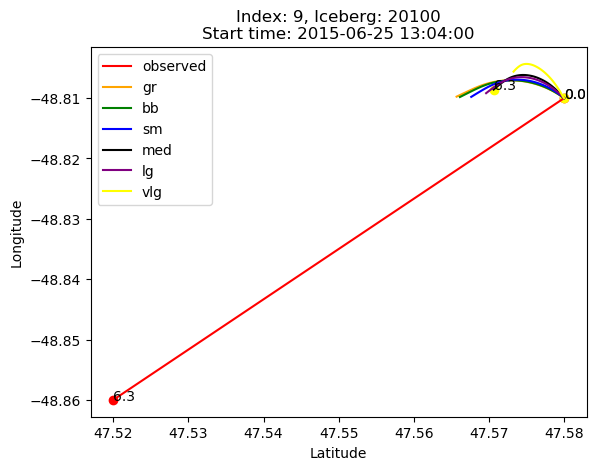

In [25]:
plot_list = []
#for chosen_track_ind in range(len(chosen_inds_arr[:])):
for chosen_track_ind in range(9,10):
    iip_berg_df = iip_df.loc[chosen_inds_arr[chosen_track_ind]].reset_index()
    iip_berg_df['t2000'] = round((iip_berg_df.DATETIME - pd.to_datetime('2000-01-01')).dt.days*24 + \
                                 (iip_berg_df.DATETIME - pd.to_datetime('2000-01-01')).dt.seconds/3600, 2)
    iip_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                       iip_berg_df['DATETIME'].loc[:].tolist(),
                       iip_berg_df['t2000'].loc[:].tolist(),
                       iip_berg_df['LATITUDE'].loc[:].tolist(),
                       iip_berg_df['LONGITUDE'].loc[:].tolist(),
                       iip_berg_df['SIZE'].loc[0])
    atm_data = ECMWF_Atm(min(iip_berg.lons), max(iip_berg.lons),
                         min(iip_berg.lats), max(iip_berg.lats),
                         iip_berg.times[0], iip_berg.times[-1])
    ocean_data = ECMWF_Ocean(min(iip_berg.lons), max(iip_berg.lons),
                             min(iip_berg.lats), max(iip_berg.lats),
                             iip_berg.times[0], iip_berg.times[-1])
    wind_u_interp = atm_data.wind_u_interp
    wind_v_interp = atm_data.wind_v_interp  
    water_u_interp = ocean_data.water_u_interp 
    water_v_interp = ocean_data.water_v_interp
    water_temp_interp = ocean_data.water_temp_interp
    # Constants
    R = 6378*1e3
    om = 7.2921e-5
    rhow = 1027
    rhoa = 1.2
    rhoi = 850
    drho = rhow - rhoi
    Cw = 0.9
    Ca = 1.3
    gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
    sst0 = -4
    Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
    CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
    CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2
    # Model Timesteps
    # Ref time is 2000-01-01
    t0 = iip_berg.t2000[0]
    tf = iip_berg.t2000[-1]
    tstep = 0.1
    t_all = np.arange(t0, tf + tstep, tstep)
    dt = tstep*3600  # timestep in seconds
    
    berg_sizes = ['GR', 'BB', 'SM', 'MED', 'LG', 'VLG']
    bergs_by_size = []
    for berg_size in berg_sizes:
        mod_berg = Iceberg(iip_berg_df['BERG_NUMBER'].loc[0],
                           [iip_berg_df['DATETIME'].loc[0]],
                           [iip_berg_df['t2000'].loc[0]],
                           [iip_berg_df['LATITUDE'].loc[0]],
                           [iip_berg_df['LONGITUDE'].loc[0]],
                           berg_size)
        mod_berg.length = [mod_berg.length]
        mod_berg.width = [mod_berg.width]
        mod_berg.height = [mod_berg.height]
        # Iceberg Initial Location
        x0, y0 = mod_berg.lons[0], mod_berg.lats[0]

        # Run number
        run_num = 0
        num_runs = 1

        # Buffer number for bounding spatial box
        buf = 0.5

        # Manual stop time
        #stop_time = 36
        stop_time = tf

        # Initialize output dict
        output_dict = {}

        for run_num in range(num_runs):

            # Iceberg Initials
            l0, w0, h0 = mod_berg.length[0], mod_berg.width[0], mod_berg.height[0]
            l0 = l0 + l0*0.1*run_num
            w0 = w0 + w0*0.1*run_num
            h0 = h0 + h0*0.1*run_num
            l, w, h = l0, w0, h0
            x, y = x0, y0
            t = t0
            #iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

            print('Run number: {}, h = {}, l = {}, w = {}'.format(run_num, h0, l0, w0))

            while t < stop_time:

                #print('Timestep: {}'.format(t))

                x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

                if x_new > max(iip_berg.lons)+buf or x_new < min(iip_berg.lons)-buf or y_new > max(iip_berg.lats)+buf or y_new <= min(iip_berg.lats)-buf:
                    # Iceberg out-of-bounds
                    print('out-of-bounds')
                    break


                if l_new <= 0 or w_new <= 0 or h_new <= 0:
                    # Iceberg melted
                    print('melted')
                    break

                else:
                    x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
                    t += tstep
                    t = round(t, 1)
                    #iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
                    mod_berg.times_ref0.append(t)
                    mod_berg.t2000.append(t)
                    mod_berg.lons.append(x)
                    mod_berg.lats.append(y)
                    mod_berg.length.append(l)
                    mod_berg.width.append(h)
                    #iceberg = np.column_stack((iceberg, iceberg_new))
                    
        print("Final time: {}".format(t)) 
        bergs_by_size.append(mod_berg)
        
    #plot1(iip_berg, mod_berg)
    #plot = plot_return(iip_berg, mod_berg)
    plot = plot_return_size_vary(iip_berg, bergs_by_size[0], bergs_by_size[1],
                                bergs_by_size[2],bergs_by_size[3],bergs_by_size[4],
                                bergs_by_size[5], chosen_track_ind)
    plot_list.append(plot)
    if not os.path.exists('plots'):
        os.makedirs('plots')
    with PdfPages('plots/plots_size_vary_9.pdf') as pdf:
        for plot in plot_list:
            pdf.savefig(plot)

In [71]:
iip_df_9 = iip_df.loc[iip_df['BERG_NUMBER']==20100].loc[579:580]

In [74]:
iip_df_9

,ICE-YEAR,BERG_NUMBER,DATE,TIME,LATITUDE,LONGITUDE,METHOD,SIZE,SHAPE,SOURCE,DATETIME,t2000
579,2015,20100,6/25/2015,1304,47.58,-48.81,R/V,LG,GEN,GTJZ,2015-06-25 13:04:00,135709.07
580,2015,20100,6/25/2015,1924,47.52,-48.86,R/V,LG,DD,GPGR,2015-06-25 19:24:00,135715.40


In [70]:
from pandas.tools.plotting import table

In [41]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [42]:
from matplotlib.animation import FuncAnimation

In [43]:
from IPython.display import HTML

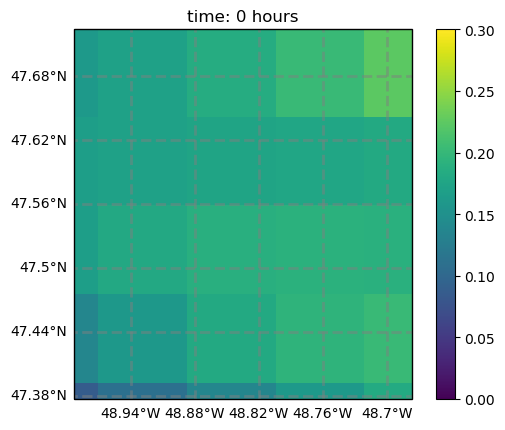

In [44]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([ocean_data.x_min, ocean_data.x_max, ocean_data.y_min, ocean_data.y_max], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#ax.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'])

#line, = plt.plot(real_berg_track.LONGITUDE.values[0], real_berg_track.LATITUDE.values[0], 'o')
water_mag = np.sqrt(ocean_data.water_u**2 + ocean_data.water_v**2)
#plt.colorbar
im = plt.imshow(water_mag[0,:,:], extent=[ocean_data.lons[0], ocean_data.lons[-1], ocean_data.lats[0], ocean_data.lats[-1]],
                origin = 'lower',vmin=0, vmax=0.3)
plt.colorbar()
title = plt.title('')


def animate(i):

    im.set_data(water_mag[i,:,:])
    '''
    time = glb_times[i]
    days = time//24
    hours = time%24
    diff = abs(time - rbt_hours_since_arr)

    if any(diff) <= 3:
        k = np.where(diff <= 3)[0]
        line.set_data(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k])
        ax.plot(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k], marker='o')

    '''    
    title.set_text('time: {:.0f} hours'.format(i))
    
    return im#, title#, line

anim = FuncAnimation(fig, animate, frames=water_mag[:,0,0].size-1)

In [45]:
HTML(anim.to_html5_video())

In [47]:
anim.save('plots/water_mag_9.gif',writer='imagemagick')

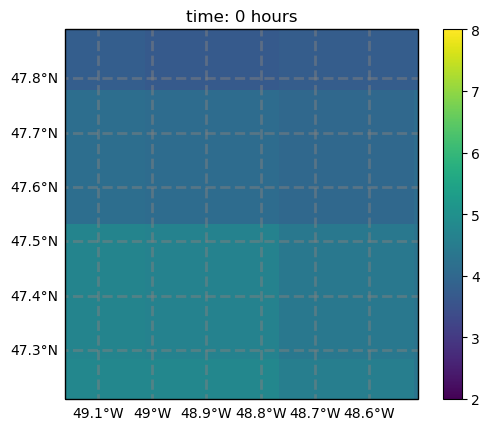

In [66]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([atm_data.x_min, atm_data.x_max, atm_data.y_min, atm_data.y_max], ccrs.PlateCarree())
#ax.stock_img()
ax.coastlines('50m')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#ax.plot(real_berg_track['LONGITUDE'], real_berg_track['LATITUDE'])

#line, = plt.plot(real_berg_track.LONGITUDE.values[0], real_berg_track.LATITUDE.values[0], 'o')
wind_mag = np.sqrt(atm_data.wind_u**2 + atm_data.wind_v**2)
#plt.colorbar
im = plt.imshow(wind_mag[0,:,:], extent=[atm_data.lons[0], atm_data.lons[-1], atm_data.lats[0], atm_data.lats[-1]],
                origin = 'lower', vmin=2, vmax=8)
#quiv = plt.quiver(atm_data.lons[:], atm_data.lats[:], atm_data.wind_u[0,:,:].T, atm_data.wind_v[0,:,:].T)
plt.colorbar()
title = plt.title('')


def animate(i):

    im.set_data(wind_mag[i,:,:])
    #quiv.set_UVC(atm_data.wind_u[i,:,:].T, atm_data.wind_v[i,:,:].T)
    '''
    time = glb_times[i]
    days = time//24
    hours = time%24
    diff = abs(time - rbt_hours_since_arr)

    if any(diff) <= 3:
        k = np.where(diff <= 3)[0]
        line.set_data(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k])
        ax.plot(real_berg_track.LONGITUDE.values[k], real_berg_track.LATITUDE.values[k], marker='o')

    '''    
    title.set_text('time: {:.0f} hours'.format(i*6))
    
    return im#, quiv#, title#, line

anim = FuncAnimation(fig, animate, frames=wind_mag[:,0,0].size-1)

In [67]:
HTML(anim.to_html5_video())

In [68]:
anim.save('plots/wind_mag_9.gif',writer='imagemagick')